# Custom Training of Breast Cancer Prediction

- Dataset: Breast Cancer Dataset 
- To predict the 'Class' is benign or malignant
- Using custom training techniques

## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools


In [2]:
tf.get_logger().setLevel('ERROR')  
#当你设置日志级别为 'ERROR' 时，这意味着只有错误（ERROR）级别的日志会被输出，而较低级别的警告（WARNING）和信息（INFO）日志将不会被输出。

## Load datasets

In [3]:
path = "./data/data.csv"
col_names = ["id", 
             "clump_thickness", 
             "un_cell_size", 
             "un_cell_shape", 
             "marginal_adheshion", 
             "single_eph_cell_size", 
             "bare_nuclei", 
             "bland_chromatin", 
             "normal_nucleoli", 
             "mitoses", 
             "class"]
df = pd.read_csv(path, names=col_names)
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Preprocess dataset

### id of dataset is useless for training.

In [4]:
df.pop("id")

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

### check unknown value

In [5]:
for i in df.columns:
    print(df[i].value_counts())

clump_thickness
1     145
5     130
3     108
4      80
10     69
2      50
8      46
6      34
7      23
9      14
Name: count, dtype: int64
un_cell_size
1     384
10     67
3      52
2      45
4      40
5      30
8      29
6      27
7      19
9       6
Name: count, dtype: int64
un_cell_shape
1     353
2      59
10     58
3      56
4      44
5      34
6      30
7      30
8      28
9       7
Name: count, dtype: int64
marginal_adheshion
1     407
3      58
2      58
10     55
4      33
8      25
5      23
6      22
7      13
9       5
Name: count, dtype: int64
single_eph_cell_size
2     386
3      72
4      48
1      47
6      41
5      39
10     31
8      21
7      12
9       2
Name: count, dtype: int64
bare_nuclei
1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: count, dtype: int64
bland_chromatin
2     166
3     165
1     152
7      73
4      40
5      34
8      28
10     20
9      11
6      10
Name: count, dtype: int

### 'bare_nuclei' 
- has a '?' value, remove it.
- 当DataFrame中的某个列包含混合类型（即数值和字符串等），pandas通常会将该列的数据类型推断为object类型。由于df['bare_nuclei']列中出现了"?"这样的非数值字符串，pandas无法将整列解释为纯数值类型（如int或float），因此该列被推断为object类型。
- pd.to_numeric 改成int64

In [6]:
df = df[df['bare_nuclei'] != '?']
df['bare_nuclei'] = pd.to_numeric(df['bare_nuclei'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   clump_thickness       683 non-null    int64
 1   un_cell_size          683 non-null    int64
 2   un_cell_shape         683 non-null    int64
 3   marginal_adheshion    683 non-null    int64
 4   single_eph_cell_size  683 non-null    int64
 5   bare_nuclei           683 non-null    int64
 6   bland_chromatin       683 non-null    int64
 7   normal_nucleoli       683 non-null    int64
 8   mitoses               683 non-null    int64
 9   class                 683 non-null    int64
dtypes: int64(10)
memory usage: 58.7 KB


### check the label "class" 
- change the label 'class' from 2,4 to 0,1;
- benign=0, malignant=1

<Axes: >

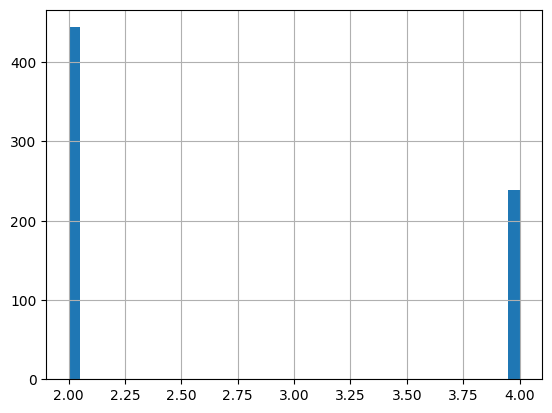

In [8]:
df['class'].hist(bins=40)

In [9]:
df['class'] = np.where(df['class']==2, 0, 1)

### train_test set split

In [10]:
train, test = train_test_split(df, test_size=0.2)

In [11]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
clump_thickness,546.0,4.503663,2.826640,1.0,2.0,4.0,6.0,10.0
un_cell_size,546.0,3.228938,3.089011,1.0,1.0,1.0,5.0,10.0
un_cell_shape,546.0,3.293040,2.993912,1.0,1.0,2.0,5.0,10.0
marginal_adheshion,546.0,2.886447,2.908059,1.0,1.0,1.0,4.0,10.0
single_eph_cell_size,546.0,3.309524,2.267719,1.0,2.0,2.0,4.0,10.0
bare_nuclei,546.0,3.622711,3.672431,1.0,1.0,1.0,7.0,10.0
bland_chromatin,546.0,3.543956,2.498970,1.0,2.0,3.0,5.0,10.0
normal_nucleoli,546.0,2.981685,3.121931,1.0,1.0,1.0,4.0,10.0
mitoses,546.0,1.617216,1.777019,1.0,1.0,1.0,1.0,10.0


### define y labels

In [12]:
train_Y = train.pop('class')
test_Y = test.pop('class')

### normalization of features

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [14]:
norm_train_X = norm(train)
norm_test_X = norm(test)

### Transfer to tensorflow's datasets
- 转换后可以用 map()、batch()、shuffle() in training pipelines later
- tf.data.Dataset.from_tensor_slices((x.values, y.values)) -> 这里使用2个括弧！
    - x.values 是一个形状为 (n_samples, n_features) 的 NumPy 数组，包含了所有样本的特征数据。
y.values 是一个形状为 (n_samples,) 的 NumPy 数组，包含了所有样本的标签数据。
    - 创建的 Dataset 对象将包含 n_samples 个元素，每个元素是一个 (feature, label) 对，其中 feature 是特征数据的一个样本，label 是对应的标签。
    - 使用2个括弧是因为我们需要传递一个元组作为参数，单个括弧在这里定义了元组的边界，而不是方法调用的边界。

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

### Shuffle and split batches

In [16]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset), seed=10).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [17]:
len(train_dataset)

18

In [18]:
t = enumerate(train_dataset)
print(len(list(t)))

18


2024-04-07 16:36:07.893039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Define models

In [19]:
num_features = len(norm_train_X.columns)

In [20]:
def base_model():
    inputs = Input(shape=(num_features,))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [21]:
model = base_model()

## Define loss and optimizer

In [22]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## Evaluate Untrained model

In [23]:
preds = model(norm_test_X.values)
loss_values = loss_object(test_Y.values, preds)

In [24]:
print("Loss before training: %0.4f" %loss_values.numpy())

Loss before training: 0.7340


## Visual - Confusion maxtrix

In [25]:
def plot_confusion_matrix(y_true, y_pred, title="confustion matrix", labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm) #显示混淆矩阵cm，创建矩阵视图
    plt.title(title)
    fig.colorbar(cax)
    #ax.set_xticklabels([''] + labels) #['']是为了对齐坐标轴
    #ax.set_yticklabels([''] + labels) 
    plt.xlabel("Prediction")
    plt.ylabel("True")
    
    fmt = 'd' #设置了文本格式化的方式。'd' 表示整数格式，
    thresh = cm.max() / 2. #阈值用来决定文本的颜色，以便在不同颜色的背景下保持文本的可读性。
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #itertools.product()+ range() ->遍历混淆矩阵的每一行和每一列的索引创建了一个组合
        #cm.shape[0] = 2; cm.shape[1] = 2
          plt.text(j, i, format(cm[i, j], fmt), 
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "red")
    plt.show()

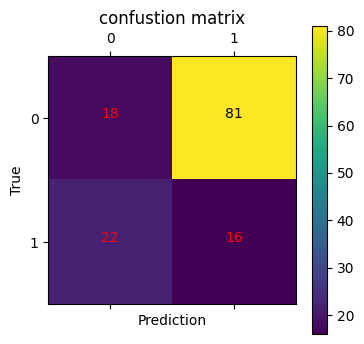

In [26]:
plot_confusion_matrix(test_Y.values, tf.round(preds))

## Define custom metrics - F1 score

**F1 Score = 2 * ((precision * recall) / (precision + recall))**

**precision = true_positives / (true_positives + false_positives)**

**recall = true_positives / (true_positives + false_negatives)**

We use `confusion_matrix` defined in `tf.math` to calculate precision and recall.

Here you can see that we have subclassed `tf.keras.Metric` and implemented the three required methods `update_state`, `result` and `reset_states`.

In [27]:
class F1score(tf.keras.metrics.Metric):
    def __init__(self, name='f1 score', **kwargs):
        super(F1score, self).__init__(name=name, **kwargs)
        self.tp = tf.Variable(0, dtype='int32')
        self.fp = tf.Variable(0, dtype='int32')
        self.tn = tf.Variable(0, dtype='int32')
        self.fn = tf.Variable(0, dtype='int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
        self.tp.assign_add(cm[1][1])
        self.fp.assign_add(cm[0][1])
        self.tn.assign_add(cm[0][0])
        self.fn.assign_add(cm[1][0])

    def result(self):
        #precision
        if (self.tp + self.fp ==0):
            precision = 1.0
        else:
            precision = self.tp/(self.tp + self.fp)
        #recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp/(self.tp + self.fn)
        #f1
        f1_score = tf.math.multiply(2, tf.math.divide(tf.math.multiply(precision, recall),tf.math.add(precision, recall)))

        return f1_score

    def reset_state(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

In [28]:
#assign to model metrics and losses

train_metric_f1 = F1score()
val_metric_f1 = F1score()

train_metric_acc = tf.keras.metrics.BinaryAccuracy()
val_metric_acc = tf.keras.metrics.BinaryAccuracy()


## Apply Gradients

In [29]:
def apply_gradients(optimizer, loss_object, model, x, y ):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_values = loss_object(y, logits)

    gradients = tape.gradient(loss_values, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return logits, loss_values

## Training Loop
- define a function for training loop for each epoch
- make updates to trainable weights
- call 'update_state' on our metrics to accumulate the values of metrics
- use **tqdm** to show progress bar

In [30]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object,
                            model, train_metric_acc, train_metric_f1, verbose=True):
    losses=[]

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        logits, loss_value = apply_gradients(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)

        logits = tf.round(logits)
        logits = tf.cast(logits, dtype='int64')

        train_metric_acc.update_state(y_batch_train, logits)
        train_metric_f1.update_state(y_batch_train, logits)

        if verbose:
            print("Training loss for step %s: loss %.4f" % (int(step), float(loss_value)))

    return losses

## Validation function

In [31]:
def perform_validation():

    losses=[]
    for x_val, y_val in test_dataset:
        val_logits = model(x_val)
        val_loss = loss_object(y_val, val_logits)
        losses.append(val_loss)
        val_logits = tf.cast(tf.round(val_logits),'int64')
        val_metric_acc.update_state(y_val, val_logits)
        val_metric_f1.update_state(y_val, val_logits)
    return losses

## Train the Model 
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

In [32]:
EPOCHS = 5
epoch_train_losses, epoch_val_losses = [],[]

for epoch in range(EPOCHS):
    print('Start of epoch %d' % (epoch,))
    
    #perform training on all batches for each epoch
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, 
                                            model, train_metric_acc, train_metric_f1,
                                           verbose=False)

    train_acc = train_metric_acc.result()
    train_f1 = train_metric_f1.result()   
    
    #perform validation on all batches of test data
    losses_val = perform_validation()
    
    val_acc = val_metric_acc.result()
    val_f1 = val_metric_f1.result()

    #calculate average metrics of current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epoch_train_losses.append(losses_train_mean)
    epoch_val_losses.append(losses_val_mean)

    #print losses & metrics
    print('''Epoch %s: Train loss: %.4f, Valid loss: %.4f, 
    Train accuracy: %.4f, Valid accuracy: %.4f, 
    Train f1-score: %.4f, Valid f1-score: %.4f''' 
          % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), 
            float(train_f1), float(val_f1)))  

    #reset metrics
    train_metric_acc.reset_state()
    train_metric_f1.reset_state()
    val_metric_acc.reset_state()
    val_metric_f1.reset_state()

Start of epoch 0
Epoch 0: Train loss: 0.2867, Valid loss: 0.1328, 
    Train accuracy: 0.9212, Valid accuracy: 0.9708, 
    Train f1-score: 0.8954, Valid f1-score: 0.9487
Start of epoch 1


2024-04-07 16:36:08.124498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 16:36:08.139512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 16:36:08.235138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 16:36:08.246136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Train loss: 0.0980, Valid loss: 0.0995, 
    Train accuracy: 0.9689, Valid accuracy: 0.9708, 
    Train f1-score: 0.9582, Valid f1-score: 0.9487
Start of epoch 2
Epoch 2: Train loss: 0.0741, Valid loss: 0.1021, 
    Train accuracy: 0.9725, Valid accuracy: 0.9708, 
    Train f1-score: 0.9630, Valid f1-score: 0.9487
Start of epoch 3
Epoch 3: Train loss: 0.0685, Valid loss: 0.1076, 
    Train accuracy: 0.9744, Valid accuracy: 0.9708, 
    Train f1-score: 0.9655, Valid f1-score: 0.9487
Start of epoch 4


2024-04-07 16:36:08.333391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 16:36:08.344468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 16:36:08.433889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 16:36:08.444381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4: Train loss: 0.0634, Valid loss: 0.1096, 
    Train accuracy: 0.9762, Valid accuracy: 0.9708, 
    Train f1-score: 0.9679, Valid f1-score: 0.9487


2024-04-07 16:36:08.535557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 16:36:08.545688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Evaluate the model

plot the loss

In [37]:
def plot_metrics(train_metrics, val_metrics, metric_name, title):
    plt.title(title)
    plt.ylim(0, 0.5)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metrics, color='blue', label=metric_name)
    plt.plot(val_metrics, color='red', label='val_'+metric_name)
    plt.legend()

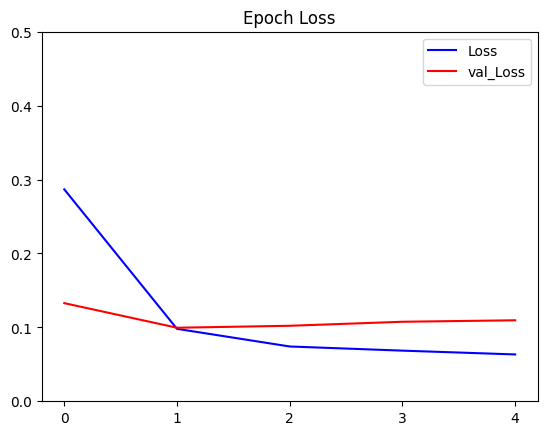

In [38]:
plot_metrics(epoch_train_losses, epoch_val_losses, "Loss", "Epoch Loss")

In [45]:
preds = model(norm_test_X.values)

print("Mean Validation Loss after training epochs: %0.4f" % np.mean(epoch_val_losses))

Mean Validation Loss after training epochs: 0.1103


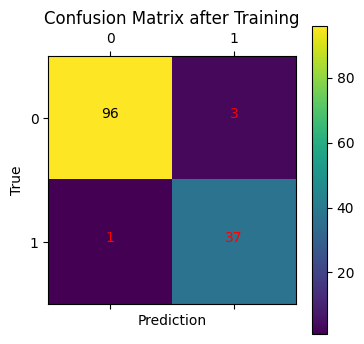

In [46]:
plot_confusion_matrix(test_Y.values, tf.round(preds), title="Confusion Matrix after Training")